In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('./10feature_cpu.csv')
df_time = pd.read_csv('./csv/10feature_cpu_date.csv')
#df.describe()

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
col = list(map(str, df.columns))
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = col

#print(df_scaled)

In [3]:
TEST_SIZE = 200

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [4]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [5]:
feature_cols = col
label_cols = ['fault']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 11), (180, 1))

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.utils import multi_gpu_model
import tensorflow as tf 
#tf.compat.v1.disable_eager_execution()

tf.device('/gpu:2')
model = Sequential()

model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))

#model = multi_gpu_model(model,gpus=4)
#model = tf.distribute.MirroredStrategy(model)


In [7]:
import os
model_path = './'

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=50)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=3000, 
                    batch_size=2048,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/3000
1/1 [==============================] - ETA: 0s - loss: 1.2026
Epoch 00001: val_loss improved from inf to 1.06518, saving model to ./tmp_checkpoint.h5
1/1 [==============================] - 0s 269ms/step - loss: 1.2026 - val_loss: 1.0652
Epoch 2/3000
1/1 [==============================] - ETA: 0s - loss: 1.0352
Epoch 00002: val_loss improved from 1.06518 to 0.91922, saving model to ./tmp_checkpoint.h5
1/1 [==============================] - 0s 71ms/step - loss: 1.0352 - val_loss: 0.9192
Epoch 3/3000
1/1 [==============================] - ETA: 0s - loss: 0.8897
Epoch 00003: val_loss improved from 0.91922 to 0.79177, saving model to ./tmp_checkpoint.h5
1/1 [==============================] - 0s 67ms/step - loss: 0.8897 - val_loss: 0.7918
Epoch 4/3000
1/1 [==============================] - ETA: 0s - loss: 0.7616
Epoch 00004: val_loss improved from 0.79177 to 0.68070, saving model to ./tmp_checkpoint.h5
1/1 [==============================] - 0s 62ms/step - loss: 0.7616 - val_loss

In [47]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

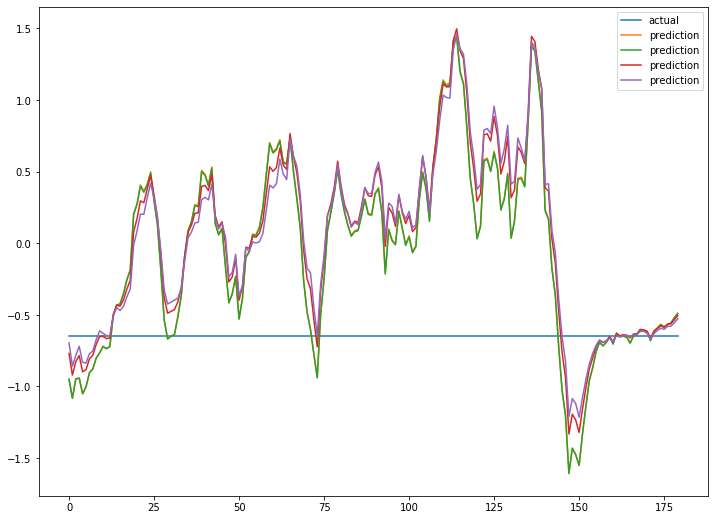

In [48]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()